# Training Deep Neural Networks

Previous problems - too simple

For more complex problems, challenges include:
- Vanishing gradients problem - making lower layers very hard to train
- Not enough training data, or too costly to label
- Training might be extremely low
- Model with millions of parameters can easily overfit - especially if training set small or noisy


This chapter:
- Vanishing gradients
- Transfer Learning + Unsupervised pretraining
- Optimizers
- Regularization techniques

In [1]:
%autosave 120

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
 
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

np.random.seed(24)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Autosaving every 120 seconds


AttributeError: module 'numpy' has no attribute 'ndarray'

# Vanishing/Exploding Gradients Problems

Problem - in back-progation, as algorithm progresses to lower layers, gradients get increasingly smaller. Hence lower layer connection weights are unchanged and training never converges. The opposite is called exploding gradients problem common in recurrent neural networks. 

KILL ME MAN - jupyter didn't fucking save again. fk this shit. if this happens again i just dont give a shit anymore.

# All notetaking contents lost. If want to find out read the book again

Quite important actually, so do look up if needed.

In [ ]:
def logit(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

## Xavier and He Initialization

## Nonsaturating Activation Functions

Leaky ReLU

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

In [ ]:
# PReLU, ELU, SELU (LeCun) etc

# Using SELU
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

In [ ]:
# Neural Net for Fashion MNIST with 100 hidden layers with SELU

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [ ]:
# Scaling with mean 0 and SD 1

pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))



| Initialization | Activation functions | O^2 (Normal) |
| :-- | :-- | :-- |
| Glorot | None, Tanh, Logistic, Softmax | 1/fan avg |
| He | ReLU & variants | 2/fan in | 
| LeCun | SELU | 1/fan in |

<br>

ELU is typically good - but its slower than ReLU, but converges daster.


### Self-Normalization


2017 Paper on Self-Normalization Neural Networks: if DNNs on stack of dense layers, and all use SELU, it will self-normalize - output of each layer preserves mean 0 and SD 1 - solving the gradients problem. Self-Normalization is generally favourbale and performs much better.

Conditions for self-normalization:
- Input features standardized (mean 0 and SD 1)
- Every hidden layer weights initialized with LeCun normal initialization
- Sequential architecture. Recurrents don't work, and don't use SELU otherwise
- All layers must be dense


Just do: keras.layers.Dense(10, activation="selu", kernel_initializer="lecun_normal")


Generally:
<br><b><i>SELU > ELU > Leaky ReLU > ReLU > tanh > logistic</i></b>

If doesn't self-normalize though, ELU tends to be better than SELU. 

## Batch Normalizaiton

Very good

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

Can add BN before or after - experiment.

Below is BN before activation functions:

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(), 
    keras.layers.BatchNormalization(), 
    keras.layers.Activation("elu"), 
    keras.layers.Activation("elu"), 
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
## Gradient Clipping - clip gradients during backpropagation

optimizer = keras.optimizers.SGD(clipvalue=1.0)

model.compile(loss="mse", optimizer=optimizer)

# Reusing Pretrained Layers

## Transfer learning

Example of Model_A and Model_B.

In [ ]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [ ]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

In [ ]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))

for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

In [ ]:
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

#Clone to make sure changes of BonA doesn't affect A
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [ ]:
# First freezing - since new output is initialized randomly, and large error gradients may wreck the reused weights.
# Better to freeze the reused layers first giving new output layer time

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

In [ ]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

# Unfreezing and continue training for tine-tuning
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

# Always compile after freezing/unfreezing layers

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

In [ ]:
model_B_on_A.evaluate(X_test_B, y_test_B)

Nice prank Geron's results were actually faked lol. Hence always be wary when a paper claims to improve training results significantly.

## Unsupervised Pretraining
and 
For complex task without much labelled data and no model on similar task. Gather unlabelled data, and try to train them with unsupervised feature detector algorihtms like Restricted Boltzmann Machines or autoencoders. Can then add output layer and fine-tune the final network with supervised learning.

Same technique which Hinton used in 2006 leading to the revival of neural networks. This was industry standard until 2010, where only after the vanishing gradients problemw as alleviated that DNNs were trained with supervised learning.

<div>
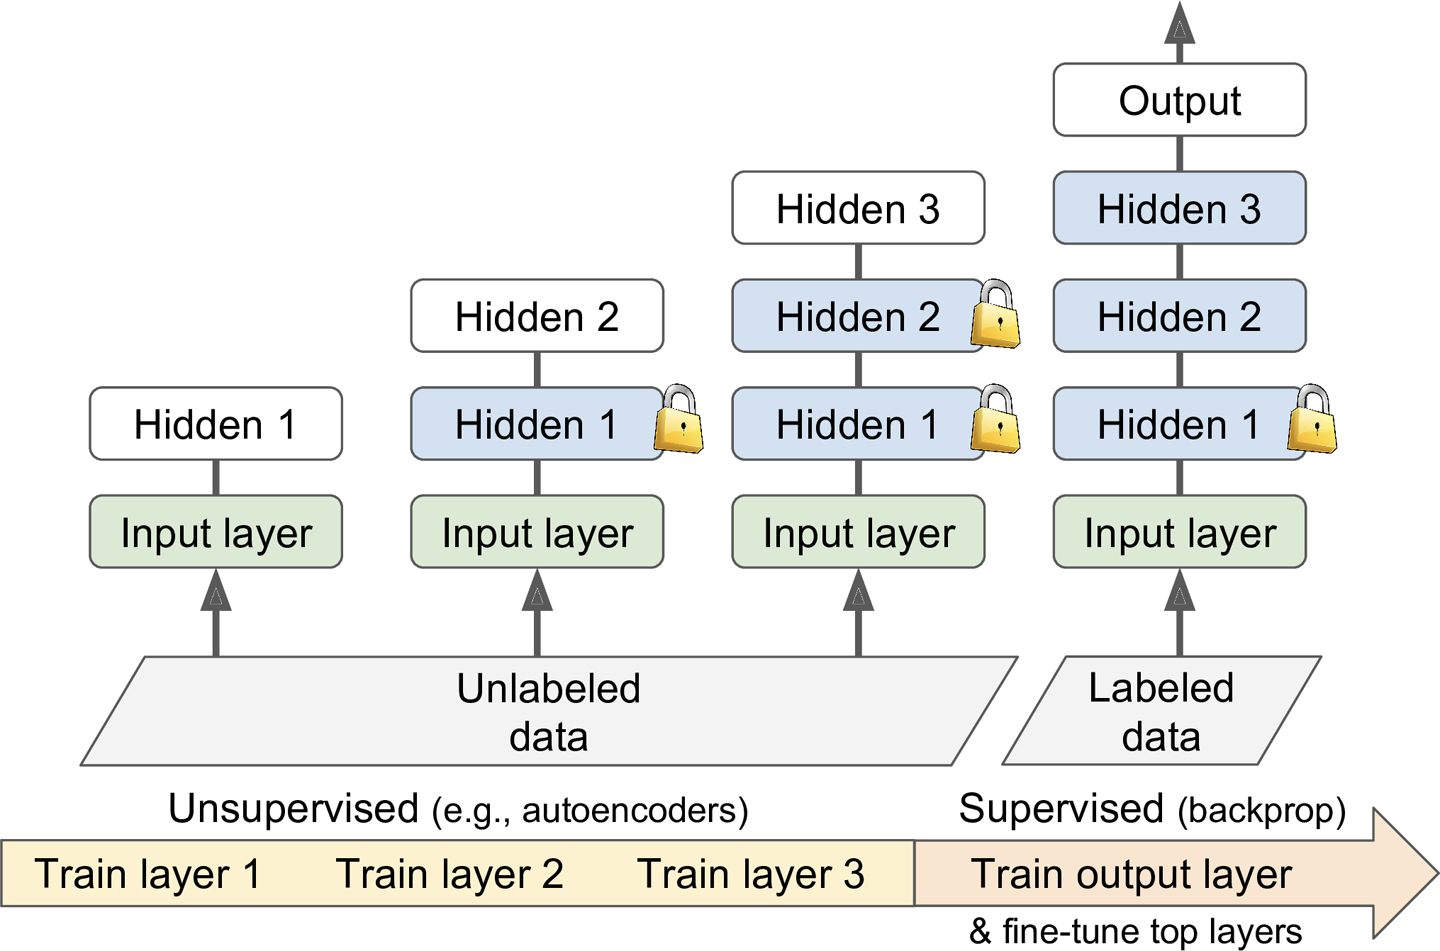
</div>


## Pretraining on an Auxiliary Task

For instance, train on small-scale, easiler task first.

Natural language processing applications, for example, can download millions of labeled data, and train first on these data to fill out missing words. Here model already knows a lot about language and can be used for subsequent task better.

# Faster Optimizers

Finally. Never thought getting onto new content is such a sweeet feeling.

Deep NNs can be painfully slow. How to speed up:
- good initilization strategy for connection weights
- good activation function
- Batch Normalization
- reusing parts of pretrained network (basically transfer)
- faster optimizer (than the regular GD optimizer)


## Momentum Optimization (MO)

At each iteration, subtracts local gradient from momentum vector m, and updates weights by adding it. Gradient is used for acceleration and not speed. Like a ball rolling - initially slow but quickly reaches terminal velocity.

Momentum - β - between 0 and 1 - typically 0.9. Good to not too high - some 'friction' gets rid of oscillations and speeds up convergence.

Very helpful - in DNNs without BN, MO helps with scaling by rolling past local optima. 

Only drawback - adds another hyperparameter to tune. 0.9 almost always works well and always faster than GD.

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

## Nesterov Accelerated Gradient (NAG)

Variant to MO and better. Measures gradient of cost function not at the local position but slightly ahead in the general direction. Slightly more accurate to use the gradient measured there rather than original.

Over time, small improvements add up to be something much better. 

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)


## AdaGrad (4 are all adaptive optimization methods)

Scales down the gradient vector along the steepest dimensions. Basically decays learning rate, and faster for steep dimensions. Adaptive learning rate. Also requires less tuning. 

Good for quadratic problems, but stops too early for DNNs. Shouldn't be used for DNNs.


## RMSProp

Fixes AdaGrad's slowing down too fast and never converging problem. 

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)


## Adam and Nadam Optimization

Adam combines MO and RMSProp - keeps track of an exponentially decaying average of past gradients, as well as an exponentially decaying average of past squared gradients. 

optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999) - the standard initialization.


#### Adamax - can be more stable than Adam - just to try

#### Nadam - Adam + Nesterov Trick

While Adaptive optimization methods are good, they can generalize poorly on some datasets - try using plain Nesterov Accelerated Gradients as some datasets are just allergic to adaptive gradients.

All discussed so far rely on first-order partial derivatives (Jacobians). Some others are based on second-order partial derivatives (Hessians), but they are not good for DNNs. 


### Training Sparse Models

All above are dense models, so most parameters are nonzero. For faster, less memory - use sparse model instead.

Can get rid of tiny weights, or apply strong L1 regularization. FTRL-Proximal in the FTRL optimizer.

## Learning Rate Scheduling

Too low - too long <br>
Too high - progress quick but might dance around the optimum and not settle down


<div>
    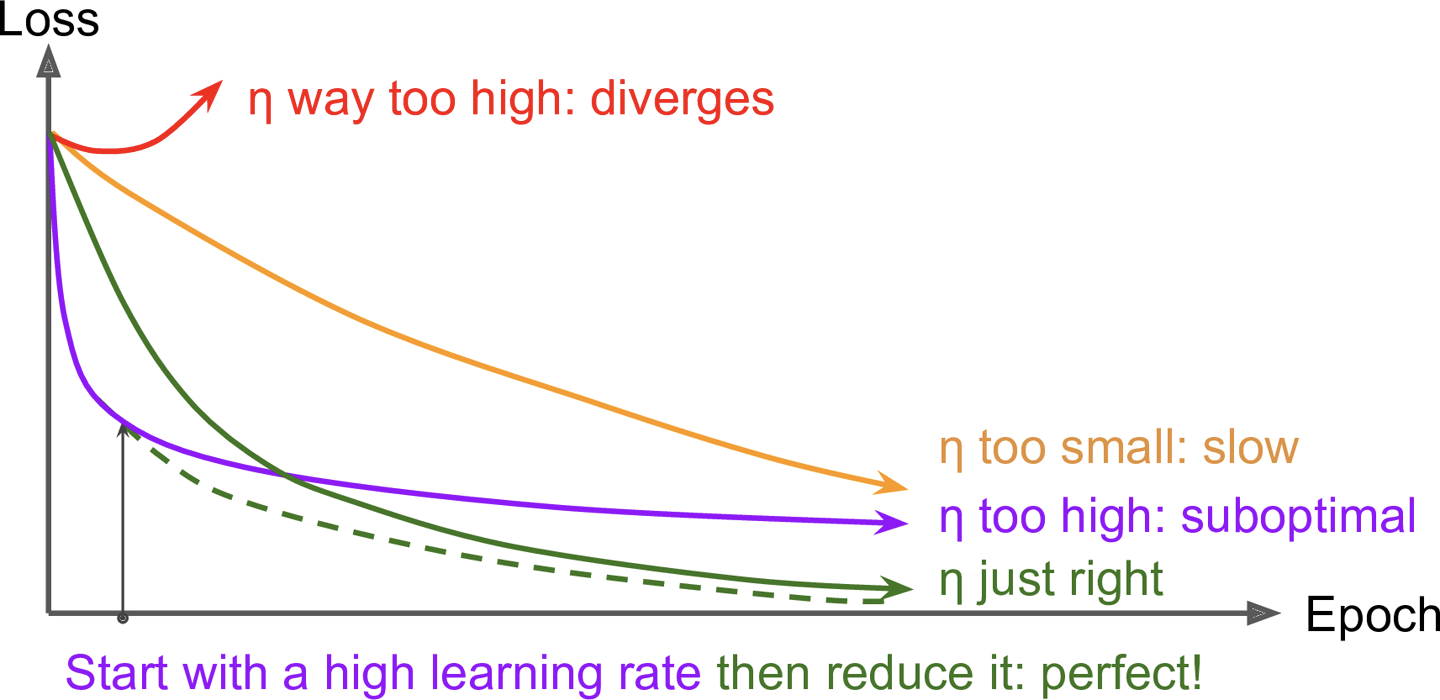
</div>


One approach is to start with large learning rate, diving it by 3 until it stops diverging. 

Rather than a constant LR, just start with high LR and reduce once it stops making fast progress - these strategies are called leanring schedules.

- Power scheduling 
- Exponential scheduling
- Piecewise constant scheduling
- Performance scheduling

Exponential is good as it's easy to tune and converges fast.

Read for details on learing rate scheduling.


# Avoiding Overfitting through regularization

With thousands and even millions of parameters, DNNs have incredible freedom and fit many complex datasets - can also overfit, which is why we need regularization.

One of the best - early stopping - see Chap 10.
Batch Normalization is also a prett good regularizer


## ℓ 1 and ℓ 2 Regularization

To constrain DNN connection weights

In [ ]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

For L1, just call keras.regularizers.l1()

For both - keras.regularizers.l1_l2()

Typically, you want the same regularizers to all layers, same activation function and same initialization strategy. Can use loops - functools.partial() to avoid errors. This creates wrapper for callables.

In [ ]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax",
                     kernel_initializer="glorot_uniform")
])

## Dropout

One of the most popular - proposed by Hinton in 2012. Highly successful.

Simple - at every training step, every neuron (including input but excluding output) has a probability p of being dropped out - entirely ignored during the step, but may be active in the next step. The hyperparameter p is called dropout rate - typically 50%. 


<div>
    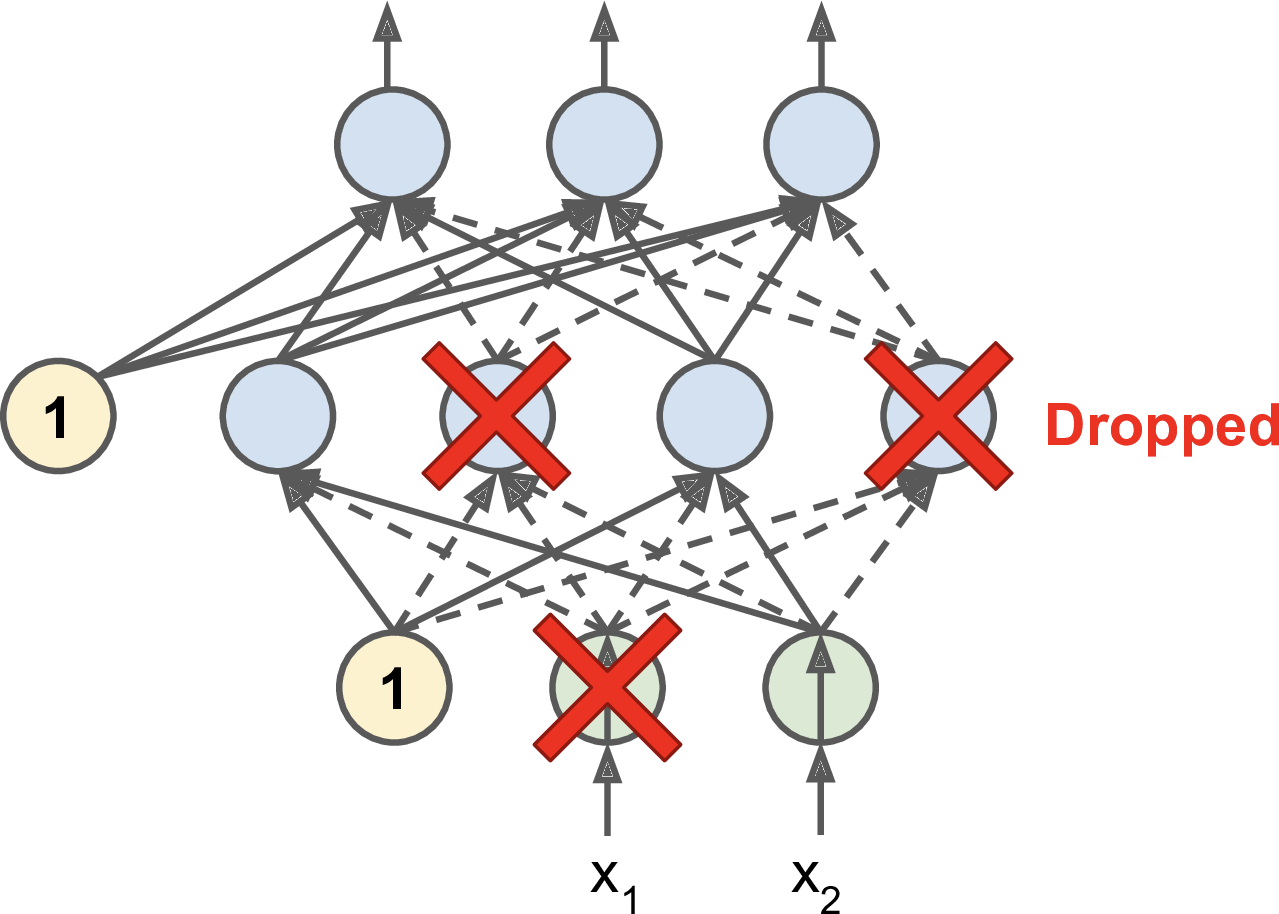
</div>

Same as for a company, all employees toss a coin to decide whether go to work or not. Company becomes much more resilient and not reliant on any specific persons. For DNNs, neurons cannot co-adapt with their neighbors and must be self-reliant. They become less sensitive to slight changes. More robust network that generalizes better.

Same as generating a unique new model every step. With 10,000 steps, literally 10,000 different neural networks - resulting one is the averaging ensemble of all. 

Small detail - during testing, we need to multiply each neuron's input connection weights by 0.5 after training

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

history = model.fit(X_train_scaled, y_train, epochs=4,
                    validation_data=(X_valid_scaled, y_valid))


# Dropout only during training - so training loss is penalized compared to validation loss - can't compare two
# Make sure to evaluate training loss without dropout

# AlphaDropout for SELU


If overfitting - can increase dropout rate for large layers, and decrease for smaller layers. Can also try using dropout after the last hidden layer - if full dropout is too strong. 

Slows down convergence significantly - but generally well worth the time. 


## Monte-Carlo Dropout (MC Dropout)

More reasons to use dropout:
- Connection between dropout networks and Bayesian inference - mathematical justification
- MC Dropout - boost dropout model without having to retrain it
- MC Dropout has better measure of model's uncertainty
- Amazingly simple to implelment

SImply:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
with keras.backend.learning_phase_scope(1): # force training mode = dropout on
    y_probas = np.stack([model.predict(X_test_scaled)]
                        for sample in range(100))
    
y_probas = y_probas.mean(axis=0)

Force training mode on using learning_phase_scope(1) - turns dropout on within the with block. Then make 100 predictions over the test set and stack them. All results will be different since dropout is on. Predict then returns a matrix with one row per instance, and one column per class - with 10,000 instances and 10 classes, matrix of shape [10000, 10]. 

We stack 100 such matrices so y_probas is an array of shape [100, 10000, 10] - we then average over the first dimension like we've made a single prediction. This is a monte carlo estimate. 

In [ ]:
np.round(model.predict(X_test_scaled[:1]), 2) # prediction for the first instance without dropout

# Almost certain its class 9

In [ ]:
np.round(y_probas[:, :1], 2)

# Predictions when dropout enabled - not sure its 9 anymore

In [ ]:
np.round(y_probas[:1], 2)

# Averaging over the first dimension - now only 62% confidence

Number of samples to use - this case 100 - is hyperparameter to be tweaked. Higher, more accurate, but time also doubled. Above certain number of samples there is also little improvement

If there are special layers (like Batch Normalization) - should not force training mode - and use MCDropout class:

In [ ]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Overall - fantastic technique that boosts dopout models with better uncertainty estimates. Also acts like regularizer.


## Max-Norm Regularization

For each neuron constrains the weights w for incoming connections. Does not add regularization loss term to the overall loss function, instead, computs ||W||2 after each training step and clipping w if needed. 

Simply set hidden layer's kernel_constraint to max_norm() constraint. 

keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal", kernel_constraints=keras.constraints.max_norm(1.))

# Summary and Practical Guidances

Default for DNN:

| Hyperparameter | Default Value |
| :-- | :-- | 
| Kernel Initializer | LeCun initialization |
| Activation function | SELU |
| Normalization | None (Self-normalization) |
| Optimizer | Nadam |
| Learning rate schedule | Performance scheduling |
| Regularization | Early stopping |

Always standardize the input features! Try reusing, or unsupervised pretraining if lots of unlabeled data, or on an auxiliary task. Dependent on the number of labeled data.

How to tweak above table:
- <b>If model self-normalizes: </b>
    - it may overfit. Add alpha dropout (also use early stopping) - don't use other regularization as they will break self-normalization. <br>
<br>    
- <b>If does not self-normalize (recurrent net or contains skip connections): </b>
    - Try ELU, and He init
    - If deep network, use Batch Normalization after every hidden layer. If overfits, use max-norm or L2 regularization. <br>
<br>
- <b>If need sparse model: </b> Use L1 regularization. If even sparser model, FTRL instead of Nadam with L1 regularization. This breaks self-normalization, so switch to BN if deep model. <br>
<br>
- <b>If low-latency model (lighting-fast predictions): </b> Less layers, avoid BN, and possibly replace SELU with leaky ReLU. Sparse model also helps. Can also reduce float precision from 32-bits to 16 or 8-bits. <br>
<br>
- <b>If risk-sensitive application: </b> or if inference latency isn't important, use MC Dropout to boost performance and get more reliable probability and uncertainty estimates. <br>


NOW ready to train very deep nets. Can go very long way just with keras. However, times, when you need more control - custom loss function or tweak the training algorithm - can use TF's lower-level API, in next chapter.